## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.datasets import load_sample_image

%matplotlib inline

def compare_images(img, img_compressed, k):
    """Show the compressed and uncompressed image side by side.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes[0].set_axis_off()
    if isinstance(k, str):
        axes[0].set_title(k)
    else:
        axes[0].set_title(f"Compressed to {k} colors")
    axes[0].imshow(img_compressed)
    axes[1].set_axis_off()
    axes[1].set_title("Original")
    axes[1].imshow(img)

# K-Means

In this first section you will implement the image compression algorithm from Bishop, chapter 9.1.1. Take an RGB image $X \in \mathbb{R}^{h \times w \times 3}$ and interpret it as a data matrix $X \in \mathbb{R}^{N \times 3}$. Now apply $k$-means clustering to find $k$ colors that describe the image well and replace each pixel with its associated cluster.

In [2]:
# Alternatively try china.jpg
X = load_sample_image("flower.jpg")

# or load your own image
# X = np.array(Image.open("/home/user/path/to/some.jpg"))

In [3]:
def kmeans(X, k):
    """Compute a k-means clustering for the data X.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
        
    Returns
    -------
    mu : np.array of size k x D
        Cluster centers
    z : np.array of size N
        Cluster indicators, i.e. a number in 0..k - 1, for each data point in X
    """
    
    # TODO: Compute mu and z
    N = X.shape[0]
    D = X.shape[1]
    z = np.zeros(N,dtype = np.int)
    Max_iteration = 5
    mu = np.random.randint(255, size=(k, D))
    
    while True:
        mu_copy = np.copy(mu)
        for i in range(N):
            min_dist,min_index = np.inf,-1
            for j in range(k):
                dist = np.linalg.norm(X[i]-mu[j])
                if dist < min_dist:
                    min_dist, min_index = dist,j
                    z[i] = j
        for j in range(k):
            mu[j] = np.mean(X[z==j],axis=0)
        if (mu_copy == mu).all():
            break
        mu *= (mu>0)
        mu = mu * (mu<=255) + 255 * (mu>255)
    return mu, z

[[225 172 115]
 [  2  70  72]
 [203 126  66]
 [  7  38  29]
 [174  52  13]]


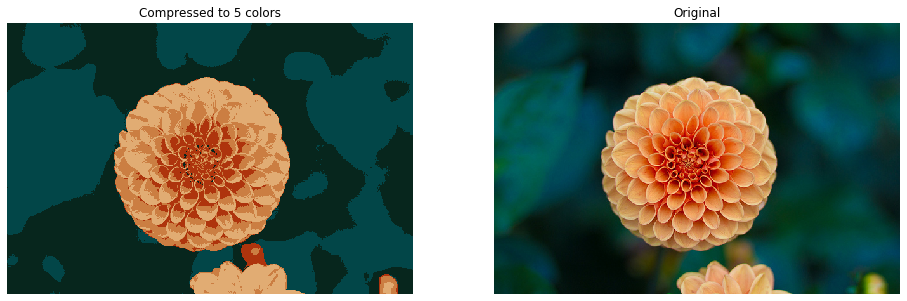

In [4]:
# Cluster the color values
k = 5
mu, z = kmeans(X.reshape((-1, 3)), k)
print(mu)

# Replace each pixel with its cluster color
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Gaussian Mixture Models & EM

Now you will repeat the same exercise with GMMs.

In [5]:
def gmm_log_probability(X, pi, mu, sigma):
    """Compute the joint log-probabilities for each data point and component.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    P : np.array of shape N x k
        P[i, j] is the joint log-probability of data point i under component j
    """
    
    # TODO: Compute P
    N = X.shape[0]
    D = X.shape[1]
    k = pi.shape[0]
    P = np.zeros((N,k))
    for i in range(N): 
        for j in range(k):
            P[i,j] = pi[j]/ np.sqrt(np.linalg.det(sigma[j])) * \
            np.exp( -1/2* np.dot(np.dot((X[i] - mu[j]).reshape(1,-1), np.linalg.inv(sigma[j])),(X[i] - mu[j]).reshape(-1,1)))
    
    return P
    

def em(X, k, tol=0.001):
    """Fit a Gaussian mixture model with k components to X.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
    tol : float
        Converge when the increase in the mean of the expected joint log-likelihood
        is lower than this
        
    The algorithm should stop when the relative improvement in the optimization
    objective is less than rtol.
    
    Returns
    -------
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    """
    
    # TODO: Compute pi, mu, sigma
    N = X.shape[0]
    D = X.shape[1]
    
    #init
    pi = np.full((1,k),1/k)
    #mu = np.random.randint(255, size=(k, D))
    mu = np.array([[202,124, 64],
         [224, 171, 114],
         [173,  50,  12],
         [  7,  38,  29],
         [  2,  70,  71]])
    sigma = np.zeros(shape = (k,D,D))
    sigma_N =  np.zeros(shape = (N,D,D))
    
    gaussian = np.zeros((N,k))
    gamma = np.zeros((N,k))
    gaussian_sum = np.zeros((N,1))
    
    log_likehood = 0
    log_likehood_increase = 0
    
   
    for j in range(k):
        for i in range (N):
            sigma_N[i] = np.dot((X[i] - mu[j]).reshape(-1,1),(X[i] - mu[j]).reshape(1,-1))
        sigma[j] =  np.mean(sigma_N,axis=0)
    print("sigma",sigma)    
    #loop     
    while True: 
    
        #E step:
        for i in range(N): 
            for j in range(k):
                gaussian[i,j] = 1/ np.sqrt(((2*np.pi)**k)*np.linalg.det(sigma[j])) *\
                np.exp( -1/2* np.dot(np.dot((X[i] - mu[j]).reshape(1,-1), np.linalg.inv(sigma[j])),(X[i] - mu[j]).reshape(-1,1)))
        gamma= (pi * gaussian)/np.sum(pi * gaussian,axis=1).reshape(-1,1)
       
        gaussian_sum = np.sum(pi * gaussian,axis = 1)
        
        #M step:
        N_k = np.sum(gamma,axis=0)
        
        for j in range(k):
            mu[j]= 1/N_k[j]*np.sum(gamma[:,j].reshape(-1,1)*X,axis=0)
            #sigma[j] = 1/N_k[j]*np.sum(gamma[:,j]* np.dot((X - mu[j]).T,X - mu[j]),axis=0  )
            #sigma[j] = 1/N_k[j]*np.sum(gamma[:,j])* np.dot((X - mu[j]).T,X - mu[j])
            for i in range (N):
                sigma_N[i] = gamma[i,j]* np.dot((X[i] - mu[j]).reshape(-1,1),(X[i] - mu[j]).reshape(1,-1))
            sigma[j] =  1/N_k[j]*np.sum(sigma_N,axis=0)
        print("mu",mu)
        print("sigma",sigma)
        pi = N_k / N 
        log_likehood_copy = log_likehood
        log_likehood = np.mean(np.log(gaussian_sum))
        if np.abs(log_likehood-log_likehood_copy) < tol:
            break
    return pi, mu, sigma

sigma [[[29493.4395748  10554.95408006  2170.63950527]
  [10554.95408006  4613.49026639  1594.46284763]
  [ 2170.63950527  1594.46284763  1152.90158811]]

 [[36439.53689622 19600.91312939 10767.92724678]
  [19600.91312939 11562.07359485  6794.50783446]
  [10767.92724678  6794.50783446  4352.88036446]]

 [[21816.22037837   370.66943428 -4161.37844701]
  [  370.66943428  2627.16757904  2302.58139271]
  [-4161.37844701  2302.58139271  3128.92366071]]

 [[10240.75877122  4862.37678206  2490.37620389]
  [ 4862.37678206  3337.06119731  2237.74262661]
  [ 2490.37620389  2237.74262661  1887.91644467]]

 [[10747.10028908  3339.97842872   398.74289008]
  [ 3339.97842872  2084.01154859  1191.42200307]
  [  398.74289008  1191.42200307  1299.8986168 ]]]
mu [[100  91  59]
 [116 111  80]
 [ 75  57  40]
 [ 20  53  42]
 [ 16  66  62]]
sigma [[[10823.0463242   4287.38286949  1222.50638829]
  [ 4287.38286949  2275.77741357  1078.08550506]
  [ 1222.50638829  1078.08550506   921.24463575]]

 [[11708.586379

mu [[192 110  53]
 [222 162 103]
 [ 83  50  24]
 [  5  35  30]
 [  0  67  66]]
sigma [[[ 9.13122882e+02  2.82391381e+01 -2.45306736e+02]
  [ 2.82391381e+01  6.11750108e+02  6.11575787e+02]
  [-2.45306736e+02  6.11575787e+02  8.68266951e+02]]

 [[ 1.64045564e+02  1.06094297e+02  9.37430364e+01]
  [ 1.06094297e+02  5.20870836e+02  5.81850758e+02]
  [ 9.37430364e+01  5.81850758e+02  7.84609901e+02]]

 [[ 4.92756988e+03 -2.59930492e+02 -6.42430794e+02]
  [-2.59930492e+02  7.75625237e+02  2.84262286e+02]
  [-6.42430794e+02  2.84262286e+02  4.08794588e+02]]

 [[ 1.83755926e+01  2.86559738e+01  2.50262561e+01]
  [ 2.86559738e+01  2.00142368e+02  1.97584022e+02]
  [ 2.50262561e+01  1.97584022e+02  2.35599676e+02]]

 [[ 8.41714846e-01 -6.44183018e-01 -6.10605713e-01]
  [-6.44183018e-01  2.09620243e+02  2.27130454e+02]
  [-6.10605713e-01  2.27130454e+02  4.05552199e+02]]]
mu [[193 109  52]
 [223 161 102]
 [ 77  50  25]
 [  5  35  30]
 [  0  68  67]]
sigma [[[ 7.95560536e+02 -2.83259864e+01 -2.54

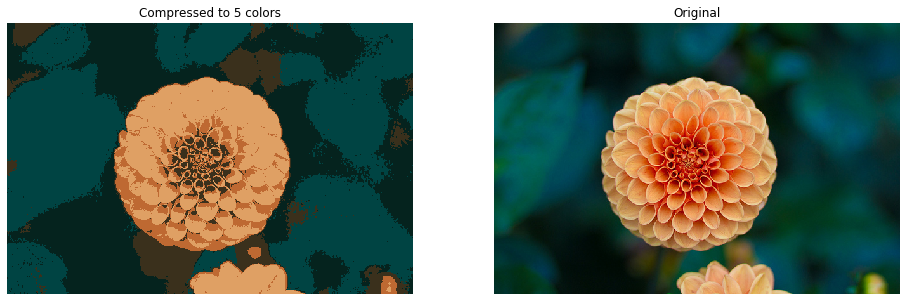

In [6]:
# Fit the GMM
k = 5
pi, mu, sigma = em(X.reshape((-1, 3)), k)

# Determine the most likely cluster of each pixel
log_p = gmm_log_probability(X.reshape((-1, 3)), pi, mu, sigma)
z = log_p.argmax(axis=1)

# Replace each pixel with its cluster mean
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Sampling Unseen Datapoints

You have trained a generative model which allows you to sample from the learned distribution. In this section, you sample new images.

In [7]:
def gmm_sample(N, pi, mu, sigma):
    """Sample N data points from a Gaussian mixture model.
    
    Parameters
    ----------
    N : int
        Number of data points to sample
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    X : np.array of shape N x D
    """
    
    # TODO: Sample X
    D = mu.shape[1]
    X = np.zeros((N,D))
    k = pi.shape[0]
    for j in range (k):
        X[int(N*np.sum(pi[0:j])):int(N*np.sum(pi[0:j]))+int(N*pi[j])] = np.random.multivariate_normal(mu[j], sigma[j], int(N*pi[j]))
    
    return X

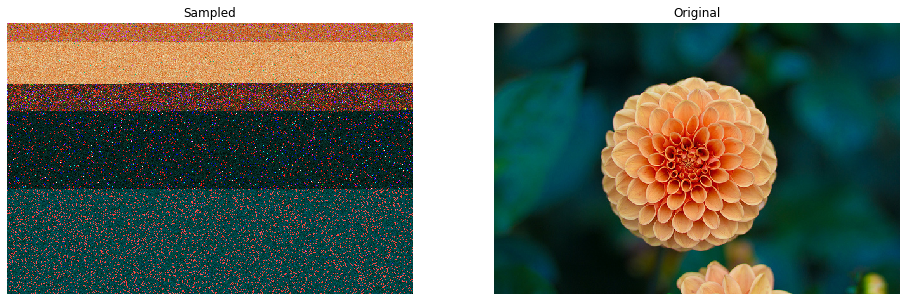

In [8]:
# Sample pixels and reshape them into the size of the original image
X_sampled = gmm_sample(np.prod(X.shape[:-1]), pi, mu, sigma).reshape(X.shape).astype(np.uint8)

# Compare the original and the sampled image
compare_images(X, X_sampled, "Sampled")

Explain what you see in the generated images. (1-3 sentences)

The proportion of different color in new sampled picture are depending on the original picture.And in every color there are still some points showing other color because of the variance.